
#  Churn Reduction Strategy for a SaaS Business

##  Objective
In this project, we aim to build an interpretable and accurate machine learning pipeline to **predict customer churn** in a subscription-based business (e.g., telecom or SaaS).

Churn prediction helps businesses:
- Improve customer retention
- Reduce revenue loss
- Optimize customer lifetime value (CLV)

We use the **IBM Telco Churn dataset** and apply:
- Data preprocessing + advanced feature engineering
- Bias-aware ML techniques (SMOTEENN, class weighting)
- XGBoost, LightGBM, CatBoost + Ensemble
- Interpretability with SHAP
- F1 & ROC-AUC metrics (accuracy is misleading in imbalanced data)


In [1]:

!pip install -q kaggle shap xgboost lightgbm catboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTEENN
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [3]:

from google.colab import files
files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d blastchar/telco-customer-churn
!unzip -o telco-customer-churn.zip
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()


Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open telco-customer-churn.zip, telco-customer-churn.zip.zip or telco-customer-churn.zip.ZIP.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## Dataset Overview

The dataset contains 7,043 customer records from a telecom company with the following:
- `tenure`, `MonthlyCharges`, `TotalCharges`
- Demographics: `SeniorCitizen`, `Partner`, `Dependents`
- Services: `InternetService`, `OnlineSecurity`, `TechSupport`, etc.
- Target: `Churn` (Yes/No)

We will:
1. Clean the data
2. Encode categories
3. Handle missing values


In [4]:

df.dropna(inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

# Encode categorical columns
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':
        df[col] = LabelEncoder().fit_transform(df[col])
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})



## EDA: Exploring Churn Patterns
We explore distributions of churn by key features.


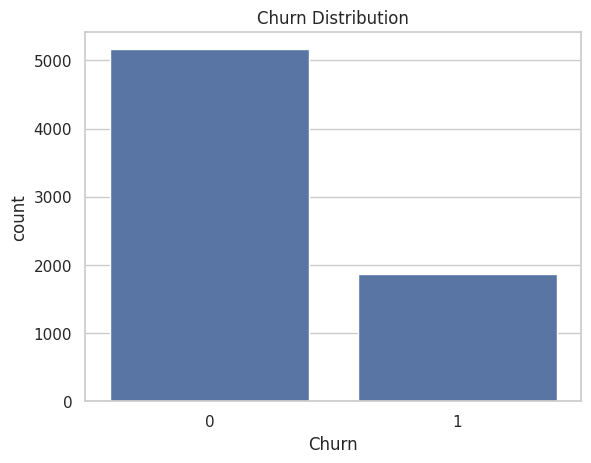

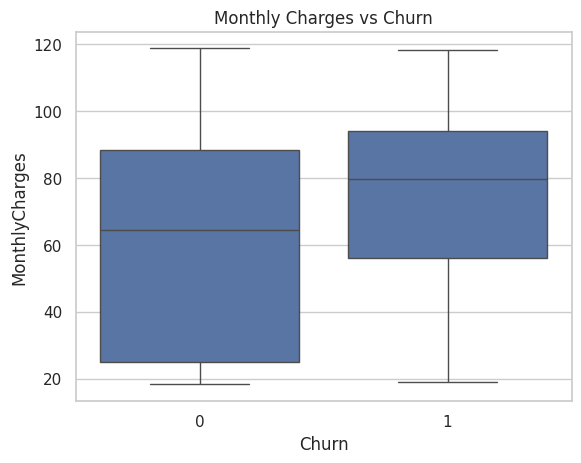

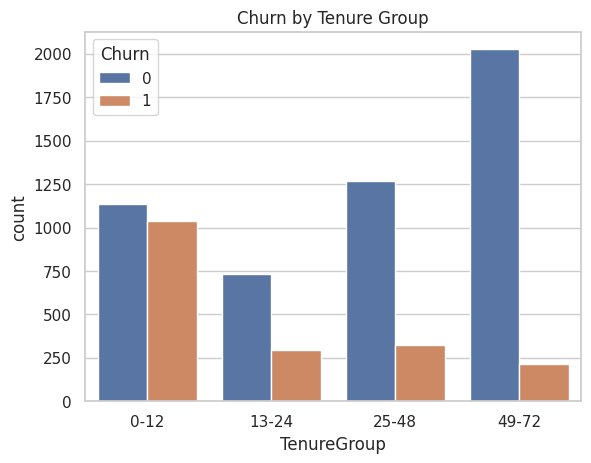

In [5]:

# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Monthly Charges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

# Tenure bins
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])
sns.countplot(x='TenureGroup', hue='Churn', data=df)
plt.title("Churn by Tenure Group")
plt.show()



## Feature Engineering

To improve model power:
- Create `CLV = MonthlyCharges * Tenure`
- Estimate `ContractLength` in months
- Add interaction terms using polynomial features


In [6]:

df['CLV'] = df['MonthlyCharges'] * df['tenure']
df['ContractLength'] = df['Contract'].map({0: 1, 1: 12, 2: 24})
X_interact = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(df[['MonthlyCharges', 'tenure', 'TotalCharges']])
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(X_interact, columns=[f"int_{i}" for i in range(X_interact.shape[1])])], axis=1)


In [7]:

X = df.drop(['Churn', 'TenureGroup'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_resampled, y_resampled = SMOTEENN().fit_resample(X_train, y_train)



## Modeling and Bias Mitigation

We train:
- XGBoost with hyperparameter tuning
- LightGBM, CatBoost
- VotingClassifier ensemble

### Why SMOTEENN?
To address class imbalance without overfitting or underfitting (combines over- and under-sampling).

###Evaluation Metrics
F1 and ROC-AUC (not accuracy) are preferred when churn class is minority.


In [8]:

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
    'max_depth': [3, 6],
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}, scoring='f1', cv=3)
xgb_grid.fit(X_resampled, y_resampled)
xgb_model = xgb_grid.best_estimator_

lgb_model = LGBMClassifier().fit(X_resampled, y_resampled)
cat_model = CatBoostClassifier(verbose=0).fit(X_resampled, y_resampled)

ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)
], voting='soft').fit(X_resampled, y_resampled)


[LightGBM] [Info] Number of positive: 2296, number of negative: 2199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 4495, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510790 -> initscore=0.043166
[LightGBM] [Info] Start training from score 0.043166
[LightGBM] [Info] Number of positive: 2296, number of negative: 2199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 4495, number of used features: 27
[LightGBM] [Info] [binary:

In [9]:

models = {'XGBoost': xgb_model, 'LightGBM': lgb_model, 'CatBoost': cat_model, 'Ensemble': ensemble}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")



XGBoost Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.75      0.82      1033
       Churn       0.53      0.76      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.77      1407

ROC AUC Score: 0.8358

LightGBM Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82      1033
       Churn       0.53      0.76      0.63       374

    accuracy                           0.76      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407

ROC AUC Score: 0.8352

CatBoost Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82      1033
       Churn       0.53      0.77      0.63       374

    accuracy                           0

**bold text**
## Interpretability with SHAP

SHAP explains model predictions and highlights:
- Which features push toward churn
- Which features retain users


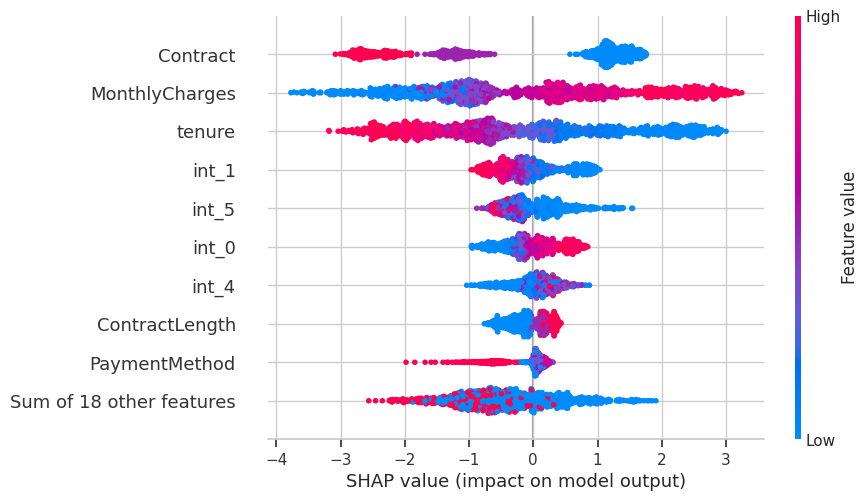

In [10]:

explainer = shap.Explainer(xgb_model, X_resampled)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)


## SHAP Interpretation: Key Drivers of Customer Churn

The SHAP beeswarm plot below provides a global explanation of how features influence the model’s churn predictions.

### Interpretation Guide
- **Color scale**:  
  - Blue represents low feature values  
  - Red represents high feature values  
- **X-axis (SHAP value)**:  
  - Positive SHAP values indicate a stronger contribution toward churn  
  - Negative SHAP values indicate a contribution toward retention

---

### Top Influential Features and Business Insights

| Feature             | Business Insight                                                                 |
|---------------------|-----------------------------------------------------------------------------------|
| MonthlyCharges      | Customers with higher monthly bills are significantly more likely to churn.      |
| Contract            | Short-term (month-to-month) contracts increase churn risk compared to long-term. |
| Tenure              | Customers with shorter tenure show a higher likelihood of churn.                 |
| OnlineSecurity      | Lack of security services correlates with increased churn likelihood.            |
| CLV (Customer Lifetime Value) | Customers with low CLV are more likely to leave the service.            |
| PaymentMethod       | Certain methods (e.g., electronic check) are associated with higher churn.       |
| OnlineBackup        | Use of backup services is associated with higher retention.                      |

---

### Strategic Recommendations

1. Promote longer-term contracts to improve retention and reduce churn volatility.
2. Launch retention offers for high-charges, short-tenure customers.
3. Bundle value-added services (such as OnlineSecurity or Backup) to increase stickiness.
4. Encourage customers to transition to more stable payment methods.
5. Segment customers by CLV and tenure to personalize engagement strategies.
